## Imports

In [1]:
import pathlib
import os
import os.path as osp
import sys
import argparse
parent_path = pathlib.Path(os.getcwd()).parent.absolute()
sys.path.append(str(parent_path))

import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch_geometric.transforms as T
from torch_geometric.datasets import MovieLens
from torch_geometric.nn import SAGEConv, to_hetero

from utils.Neo4jMovieLens import Neo4jMovieLens
from utils.gnn_simple import Model
from utils.train_test import train_test
from utils.visualize import plot_loss, plot_train, plot_val, plot_test

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read the dataset

In [3]:
path = osp.join(osp.dirname(osp.abspath('')), '../../data/MovieLensNeo4j')
dataset = Neo4jMovieLens(
    path,
    model_name='all-MiniLM-L6-v2',
    database_url="bolt://localhost:7687",
    database_username="neo4j",
    database_password="admin"
)
# path = osp.join(osp.dirname(osp.abspath('')), '../../data/MovieLens')
# dataset = Neo4jMovieLens(
#     path,
#     model_name='all-MiniLM-L6-v2',
#     database_url="bolt://localhost:7687",
#     database_username="neo4j",
#     database_password="admin"
# )
# dataset = MovieLens(path, model_name='all-MiniLM-L6-v2')
data = dataset[0].to(device)

Extracting c:\Users\GiannisAthanasiou\Desktop\diploma\repo\data\MovieLensNeo4j\raw\ml-latest-small.zip
Processing...


Batches:   0%|          | 0/296 [00:00<?, ?it/s]

Done!


#### Preprocess the dataset

In [4]:
# Add user node features for message passing:
data['user'].x = torch.eye(data['user'].num_nodes, device=device)
del data['user'].num_nodes

# Add a reverse ('movie', 'rev_rates', 'user') relation for message passing:
data = T.ToUndirected()(data)
del data['movie', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

# Perform a link-level split into training, validation, and test edges:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)

#### Define and train-test the model

In [5]:
model = Model(
    data,
    layer_name="SAGE",
    encoder_num_layers=5,
    encoder_dropout=0.1,
    encoder_skip_connections=True,
    decoder_num_layers=4,
    hidden_channels=32
).to(device)
losses = train_test(
    model=model,
    epochs=1000,
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    logging_step=1,
)

c:\Users\GiannisAthanasiou\Desktop\diploma\repo\diploma\environ\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 001, Loss: 18.3814, Train: 3.3303, Val: 3.3283, Test: 3.3312
Epoch: 002, Loss: 17.3146, Train: 3.0962, Val: 3.0976, Test: 3.0994
Epoch: 003, Loss: 15.0190, Train: 2.1655, Val: 2.2053, Test: 2.1958
Epoch: 004, Loss: 8.4902, Train: 1.9637, Val: 1.9209, Test: 1.9326
Epoch: 005, Loss: 23.8299, Train: 1.4402, Val: 1.4509, Test: 1.4596
Epoch: 006, Loss: 6.2410, Train: 2.3427, Val: 2.3509, Test: 2.3487
Epoch: 007, Loss: 9.3285, Train: 2.7262, Val: 2.7305, Test: 2.7251
Epoch: 008, Loss: 11.8707, Train: 2.8799, Val: 2.8829, Test: 2.8883
Epoch: 009, Loss: 13.1218, Train: 2.9555, Val: 2.9549, Test: 2.9542
Epoch: 010, Loss: 13.7303, Train: 2.9786, Val: 2.9781, Test: 2.9841
Epoch: 011, Loss: 13.9557, Train: 2.9808, Val: 2.9812, Test: 2.9855
Epoch: 012, Loss: 13.9725, Train: 2.9651, Val: 2.9700, Test: 2.9703
Epoch: 013, Loss: 13.8849, Train: 2.9415, Val: 2.9421, Test: 2.9450
Epoch: 014, Loss: 13.6258, Train: 2.9079, Val: 2.9046, Test: 2.9060
Epoch: 015, Loss: 13.3260, Train: 2.8501, Val: 2.85

#### Visualize

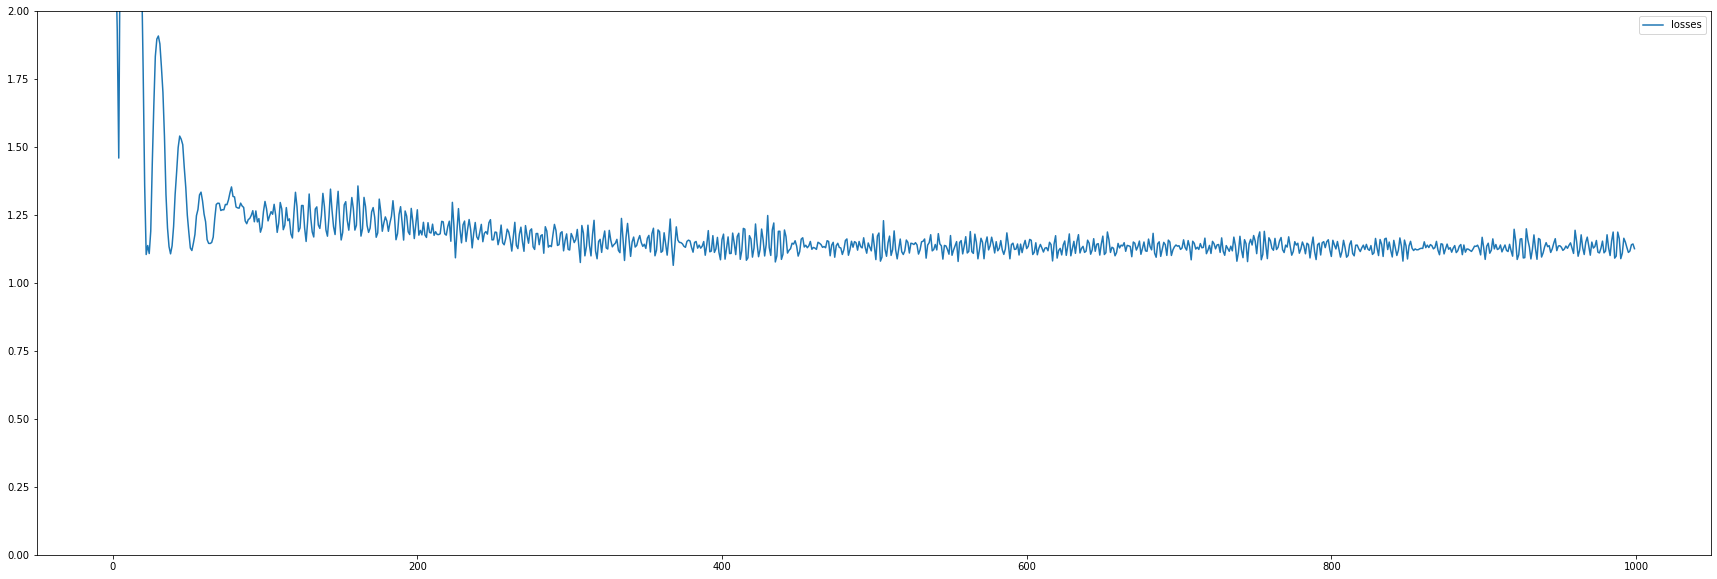

In [12]:
plot_test({ "losses": losses }, ylim=2)